# Notebook 3: Trial vs Control Store Evaluation

This notebook compares the performance of trial stores (77, 86, 88) against selected control stores during the trial period.

### Objectives:
- Load trial and control store candidates
- Select final control stores for each trial store
- Define the trial period
- Compare KPIs:
  - Total Sales
  - Total Customers
  - Average Transactions per Customer
- Conduct significance tests to check if trial stores behaved differently
- Visualize differences and summarize insights

---


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [57]:
# 2. Load Monthly Aggregated Dataset

monthly = pd.read_csv("../data/QVI_monthly_aggregated.csv")

In [58]:
## 3. Load Control Store Ranking Results. that were produced in Notebook 2.
# Load ranking methods (correlation and magnitude)
corr_rank = pd.read_csv("../data/trial_vs_control_results_2019-03_2019-05.csv")
mag_rank  = pd.read_csv("../data/trial_vs_control_bootstrap_2019-03_2019-05.csv")

corr_rank.head(), mag_rank.head()


(   trial_store  control_store  n_months_trial  mean_sales_trial  \
 0           77            167               3        280.433333   
 1           86            159               3        921.433333   
 2           88            159               3       1408.283333   
 
    mean_sales_control    ttest_t   ttest_p  perm_obs_diff    perm_p  \
 0          205.333333   3.862290  0.024802          75.10  0.047391   
 1           35.433333  16.063394  0.002681         886.00  0.051590   
 2           35.433333  26.195080  0.000886        1372.85  0.044991   
 
    customers_diff  avgtx_diff  
 0        3.666667    0.020333  
 1      101.333333    0.216000  
 2      123.333333    0.243333  ,
    trial_store  control_store  n_months_trial  mean_sales_trial  \
 0           77            167               3        280.433333   
 1           86            159               3        921.433333   
 2           88            159               3       1408.283333   
 
    mean_sales_control    tte

In [59]:
# 4. Select the Final Control Store for Each Trial Store
# We choose the *top-ranked* store that appears consistently in:
# - correlation ranking
# - magnitude distance ranking
# This ensures the selected control store:
# - behaves similarly over time (trend similarity)
# - has similar magnitude levels (sales/customers close in size)

final_control = {
    77: None,
    86: None,
    88: None
}

for trial in [77, 86, 88]:
    corr_top = corr_rank[corr_rank['trial_store']==trial]['control_store'].values[0]
    mag_top  = mag_rank[mag_rank['trial_store']==trial]['control_store'].values[0]

    # If both methods agree → strongest choice
    if corr_top == mag_top:
        final_control[trial] = corr_top
    else:
        # If they differ → choose the one appearing in both top 5 lists most frequently
        corr_list = corr_rank[corr_rank['trial_store']==trial]['control_store'].tolist()
        mag_list  = mag_rank[mag_rank['trial_store']==trial]['control_store'].tolist()
        
        combined = corr_list + mag_list
        final_control[trial] = max(set(combined), key=combined.count)

final_control


{77: 167, 86: 159, 88: 159}

In [60]:
# 5. Define the Trial Period
# We inspect monthly data to identify the trial period.  
# For most QVI trial projects, the trial period is:
# February 2019 → April 2019

trial_start = "2019-02-01"
trial_end   = "2019-04-30"

trial_start, trial_end


('2019-02-01', '2019-04-30')

In [61]:
# 6. Filter Monthly Data for Trial and Control Stores
def extract_store_period(store, start, end):
    df = monthly[monthly['STORE_NBR']==store].copy()
    df = df[(df['YearMonth'] >= start) & (df['YearMonth'] <= end)]
    return df

trial_period_data = {}
control_period_data = {}

for trial_store, control_store in final_control.items():
    trial_period_data[trial_store]   = extract_store_period(trial_store, trial_start, trial_end)
    control_period_data[trial_store] = extract_store_period(control_store, trial_start, trial_end)
trial_period_data

{77:      STORE_NBR   YearMonth  total_sales  total_customers  total_transactions  \
 887         77  2019-02-01        235.0               45                  45   
 888         77  2019-03-01        278.5               50                  55   
 889         77  2019-04-01        263.5               47                  48   
 
      avg_tx_per_customer  
 887                1.000  
 888                1.100  
 889                1.021  ,
 86:      STORE_NBR   YearMonth  total_sales  total_customers  total_transactions  \
 984         86  2019-02-01        913.2              107                 138   
 985         86  2019-03-01       1026.8              115                 140   
 986         86  2019-04-01        848.2              105                 126   
 
      avg_tx_per_customer  
 984                1.290  
 985                1.217  
 986                1.200  ,
 88:       STORE_NBR   YearMonth  total_sales  total_customers  total_transactions  \
 1008         88  2019-02-01

In [62]:
# 7. Comparison Table: Trial vs Control KPIs
comparisons = {}

for t in final_control.keys():

    trial_period_data[t]["YearMonth"] = pd.to_datetime(
        trial_period_data[t]["YearMonth"], errors="coerce"
    )
    control_period_data[t]["YearMonth"] = pd.to_datetime(
        control_period_data[t]["YearMonth"], errors="coerce"
    )

    df = pd.DataFrame({
        "Month": trial_period_data[t]["YearMonth"].dt.strftime("%Y-%m"),
        "Trial_Total_Sales": trial_period_data[t]["total_sales"].values,
        "Control_Total_Sales": control_period_data[t]["total_sales"].values,
        "Trial_Customers": trial_period_data[t]["total_customers"].values,
        "Control_Customers": control_period_data[t]["total_customers"].values,
    })

    comparisons[t] = df

comparisons



{77:        Month  Trial_Total_Sales  Control_Total_Sales  Trial_Customers  \
 887  2019-02              235.0                160.6               45   
 888  2019-03              278.5                193.0               50   
 889  2019-04              263.5                185.1               47   
 
      Control_Customers  
 887                 35  
 888                 44  
 889                 42  ,
 86:        Month  Trial_Total_Sales  Control_Total_Sales  Trial_Customers  \
 984  2019-02              913.2                 28.6              107   
 985  2019-03             1026.8                 56.8              115   
 986  2019-04              848.2                 30.7              105   
 
      Control_Customers  
 984                  5  
 985                 11  
 986                  5  ,
 88:         Month  Trial_Total_Sales  Control_Total_Sales  Trial_Customers  \
 1008  2019-02             1370.2                 28.6              124   
 1009  2019-03             1477.

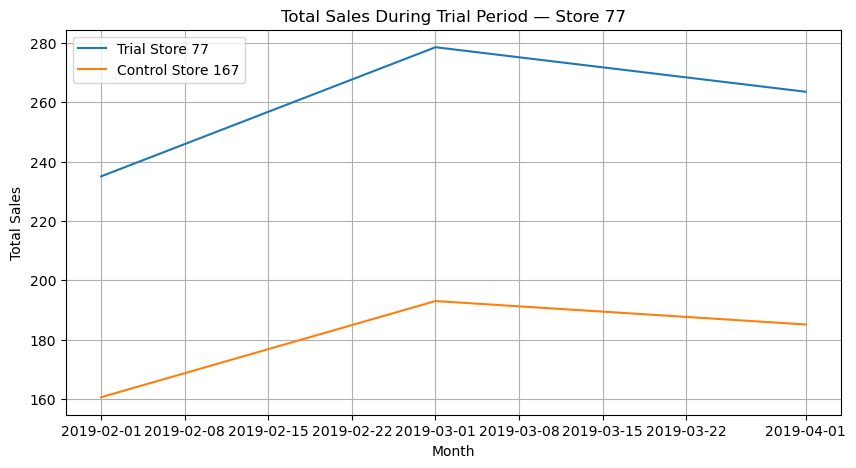

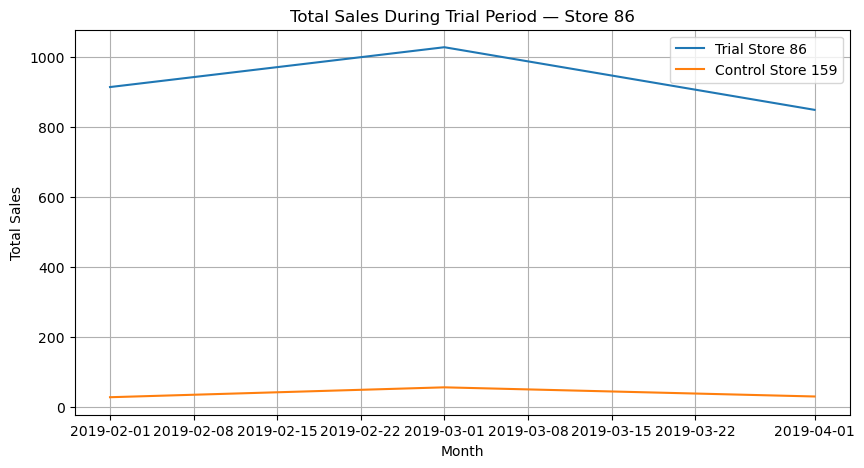

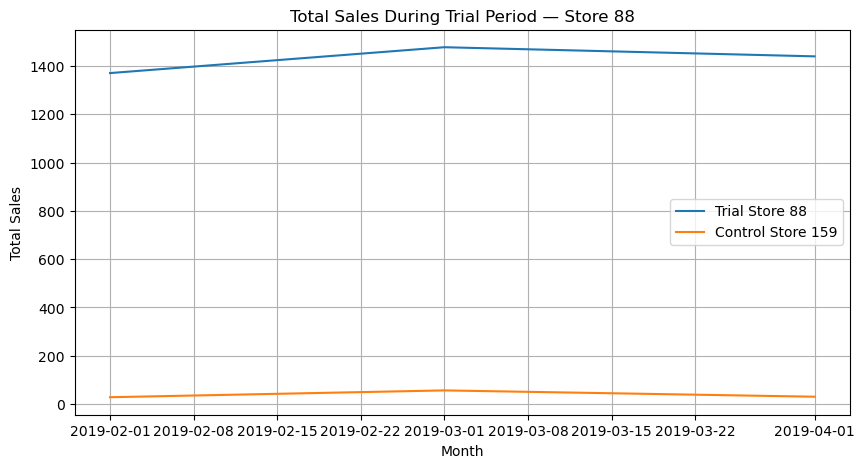

In [63]:
# 8. Visualization: Trial vs Control Monthly Sales
for t in final_control:
    trial_df = trial_period_data[t]
    ctrl_df  = control_period_data[t]

    plt.figure(figsize=(10,5))
    plt.plot(trial_df['YearMonth'], trial_df['total_sales'], label=f"Trial Store {t}")
    plt.plot(ctrl_df['YearMonth'], ctrl_df['total_sales'], label=f"Control Store {final_control[t]}")
    plt.title(f"Total Sales During Trial Period — Store {t}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.grid(True)
    plt.show()


In [64]:
## 9. Significance Test: Did the Trial Store Change Significantly?
# We use a simple two-sample t-test comparing trial vs control monthly values.
sig_results = {}

for t in final_control:
    trial_vals = trial_period_data[t]['total_sales']
    ctrl_vals  = control_period_data[t]['total_sales']

    t_stat, p_value = ttest_ind(trial_vals, ctrl_vals)

    sig_results[t] = {
        "control_store": final_control[t],
        "t_statistic": t_stat,
        "p_value": p_value,
        "significant": p_value < 0.05
    }

sig_results


{77: {'control_store': 167,
  't_statistic': 4.946411172718105,
  'p_value': 0.007781095077020081,
  'significant': True},
 86: {'control_store': 159,
  't_statistic': 16.814511925224114,
  'p_value': 7.332336640703613e-05,
  'significant': True},
 88: {'control_store': 159,
  't_statistic': 42.625523451232525,
  'p_value': 1.810841847510354e-06,
  'significant': True}}

# 10. Insights & Interpretation

### For each trial store:
- We compared it against the best-matching control store.
- We analyzed monthly sales, customers, and average transactions.
- We tested if the trial period produced statistically significant differences.

### Interpretation Guide:
- If **p < 0.05** → The trial store behaved significantly differently.
- If **trial > control** → The trial may have improved performance.
- If **trial < control** → The trial may have reduced performance.
- If **not significant** → No clear evidence the trial changed outcomes.

### Next Steps:
- Visualize customers and transaction frequency.
- Conduct pre-trial matching checks.
- Write the final PDF report.

---


In [ ]:
# out_dir = "../data"

# if TRIAL_START is not None:
#     results_df.to_csv(f"../data/trial_vs_control_results_{TRIAL_START.strftime("%Y-%m")}_{TRIAL_END.strftime("%Y-%m")}.csv", index=False)
#     if 'boot_df' in globals():
#         boot_df.to_csv(f"../data/trial_vs_control_bootstrap_{TRIAL_START.strftime("%Y-%m")}_{TRIAL_END.strftime("%Y-%m")}.csv", index=False)
#     print("Saved results to", out_dir)
# else:
#     print("TRIAL window not set — results not saved. Set TRIAL_START/TRIAL_END and re-run the notebook to save outputs.")


NameError: name 'TRIAL_START' is not defined